In [17]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task, Dataset

from amplify.data import DataGenerator, DataSplit

## Load Data

In [18]:
# DataGenerator - ClearML
# xy_data = DataGenerator().load_data()

# Load Data
data_dir = glob(
    Dataset.get(
        dataset_name="xy_data",
        dataset_project="amplify",
    ).get_local_copy()
    + "/**"
)[0]

xy_data = pd.read_csv(data_dir, index_col=0)
xy_data.shape


(2713, 9)

## Data Processing

In [19]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="encoder-decoder-lstm", output_uri="s3://amplify-microgrid-ai")

ClearML Task: created new task id=0f6f7fbd1c7a45c6af705589e7468a99
======> WARNING! Git diff to large to store (512kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/0f6f7fbd1c7a45c6af705589e7468a99/output/log


In [20]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [21]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds, norm_layer = DataSplit(xy_data, series_length=SERIES, stride=STRIDE, train_pct=.8, val_pct=.1, test_pct=.1).split_data()

Info: Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y), (norm_layer)!


In [22]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


### Reviewing Data

In [23]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


x_train shape:  (2122, 48, 7)
y_train shape:  (2122, 48, 2)


## Modeling

In [24]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [25]:
# Define the model 
inputs = Input(shape=(SERIES, x_train.shape[-1]))
x = norm_layer(inputs)
x = LSTM(400, return_sequences=True, dropout=.2)(x)
outputs = TimeDistributed(Dense(y_train.shape[-1], activation='relu', kernel_regularizer='l2'))(x)
model = Model(inputs, outputs)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 normalization_1 (Normalizat  (None, 48, 7)            15        
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 48, 400)           652800    
                                                                 
 time_distributed_1 (TimeDis  (None, 48, 2)            802       
 tributed)                                                       
                                                                 
Total params: 653,617
Trainable params: 653,602
Non-trainable params: 15
_________________________________________________________________


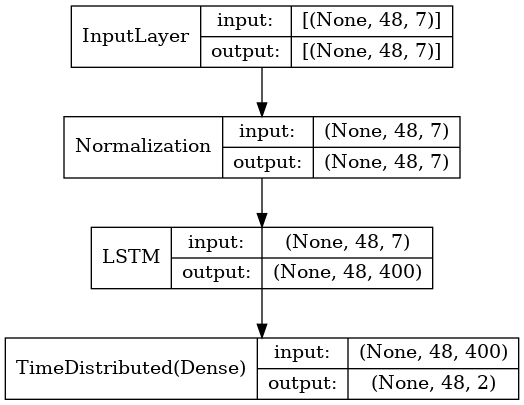

In [26]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [27]:
# Hyperparameters and callbacks

BATCH  = 1
EPOCHS = 100
LRATE = .005
FACTOR = .8
PATIENCE = 2
log_dir = os.path.join('../','logs')
model_path = os.path.join('../', 'models', "lstm_weights.hdf5")

def scheduler(epoch):
    return LRATE / (epoch % 10 + 1)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1),
    # tf.keras.callbacks.LearningRateScheduler(scheduler),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', 
    #     mode='min', 
    #     factor=FACTOR,
    #     patience=PATIENCE, 
    #     min_lr=1e-8, 
    #     verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode='min', 
        patience=25, 
        verbose=1)
]

In [28]:
# try:
#     model.load_weights(model_path)
# except Exception:
#     pass

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LRATE), 
    #loss=tf.keras.losses.Huber(), # Less sensitive to outliers 
    loss=tf.keras.losses.MeanSquaredError(),  # More sensitive to outliers 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
2119/2122 [============================>.] - ETA: 0s - loss: 27.0477 - root_mean_squared_error: 5.1612
Epoch 00001: val_loss improved from inf to 25.93200, saving model to ../models/lstm_weights.hdf5
2122/2122 [==============================] - 13s 6ms/step - loss: 27.0386 - root_mean_squared_error: 5.1603 - val_loss: 25.9320 - val_root_mean_squared_error: 5.0473
2022-02-11 23:16:55,809 - clearml.storage - INFO - Starting upload: /tmp/.clearml.upload_model_xjm5wrm8.tmp => amplify-microgrid-ai/amplify/encoder-decoder-lstm.0f6f7fbd1c7a45c6af705589e7468a99/models/lstm_weights.hdf5
Epoch 2/100
2117/2122 [============================>.] - ETA: 0s - loss: 19.7869 - root_mean_squared_error: 4.3967
Epoch 00002: val_loss did not improve from 25.93200
2122/2122 [==============================] - 9s 4ms/step - loss: 19.7781 - root_mean_squared_error: 4.3957 - val_loss: 30.5200 - val_root_mean_squared_error: 5.4822
Epoch 3/100
2114/2122 [============================>.] - ETA: 0s - loss

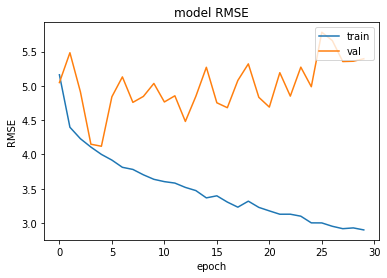

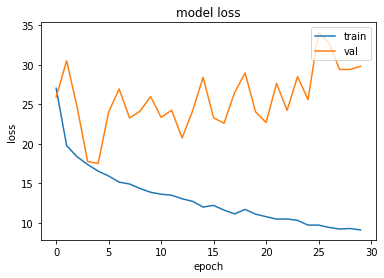

In [29]:
def plot_history(history, metric):
    # This function will plot the model fit process
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [40]:
# Evaluate and make predictions
model.load_weights(model_path)
scores = model.evaluate(x_val, y_val, verbose=1)
scores = model.evaluate(x_test, y_test, verbose=1)
y_preds = model.predict(x_test, verbose=1)


2022-02-11 23:24:15,870 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=0f6f7fbd1c7a45c6af705589e7468a99, name=lstm_weights, model=f6b26b93ecc842319d0733711523f22e, type=input)
7/7 [==============================] - 0s 3ms/step


Net Energy Error 24.928593635559082 kWh


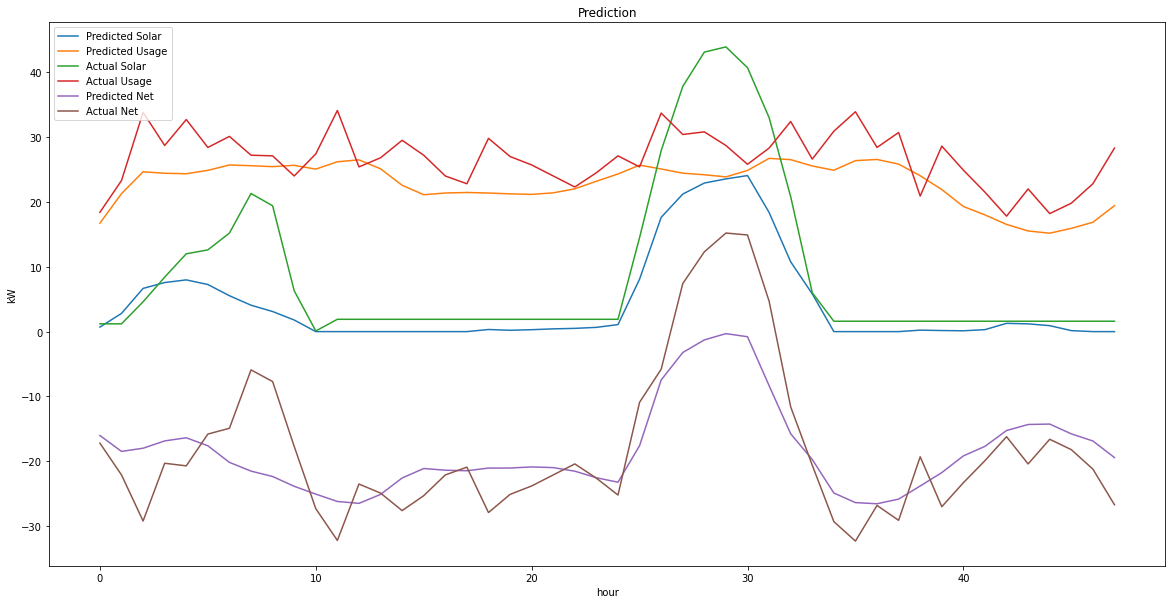

In [322]:
x = np.random.default_rng().integers(0, y_preds.shape[0])
print("Net Energy Error {} kWh".format(sum(y_test[x,:,0]-y_test[x,:,1])-sum(y_preds[x,:,0]-y_preds[x,:,1])))

plt.figure(figsize=(20, 10))
plt.title('Prediction')
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.plot(y_preds[x,:,0]-y_preds[x,:,1])
plt.plot(y_test[x,:,0]-y_test[x,:,1])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage', 'Predicted Net', 'Actual Net'], loc='upper left')
plt.show()


In [32]:
task.close()